<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Initialization" data-toc-modified-id="Initialization-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Initialization</a></span></li><li><span><a href="#Agent" data-toc-modified-id="Agent-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Agent</a></span><ul class="toc-item"><li><span><a href="#ReplayBuffer" data-toc-modified-id="ReplayBuffer-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>ReplayBuffer</a></span></li><li><span><a href="#Ornstein-Uhlenbeck-Process" data-toc-modified-id="Ornstein-Uhlenbeck-Process-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Ornstein-Uhlenbeck-Process</a></span></li><li><span><a href="#DDPG-Agent" data-toc-modified-id="DDPG-Agent-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>DDPG Agent</a></span><ul class="toc-item"><li><span><a href="#Initialization" data-toc-modified-id="Initialization-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Initialization</a></span></li><li><span><a href="#Updates" data-toc-modified-id="Updates-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Updates</a></span></li></ul></li></ul></li><li><span><a href="#Training" data-toc-modified-id="Training-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Plotting-Results" data-toc-modified-id="Plotting-Results-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Plotting Results</a></span><ul class="toc-item"><li><span><a href="#Plotting-Trajectories" data-toc-modified-id="Plotting-Trajectories-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Plotting Trajectories</a></span></li></ul></li><li><span><a href="#Demo" data-toc-modified-id="Demo-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Demo</a></span><ul class="toc-item"><li><span><a href="#Simple-hardcoded-agent" data-toc-modified-id="Simple-hardcoded-agent-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Simple hardcoded agent</a></span></li></ul></li></ul></div>

*This notebook contains all the code and explanations that together make up our final project.*

# Introduction

At the ICLR 2016 (Lillicrap et al., 2016) published a paper called "Continuous Control with Deep Reinforcement Learning". In this paper the authors introduce a refined reinforcement learning algorithm named Deep Deterministic Policy Gradient ("DDPG"). Their reported results indicate that using the same hyperparamters, the DDPG agent robustly solves various physical control problems with continuous action spaces, outperforming the original DPG (Silver et al., 2014) on which it builds and a planning algorithm (Tassa et al., 2012). A simple reinforcement learning task that they have not included in their report is the continuous version of OpenAI's "Mountain Climber".

Our project is a replication attempt of the 2016 report, focusing on the mountain climber problem with a continuous action space. We will begin with writing a tensorflow2/keras implementation of the algorithm and using the exact same parameters as the authors did. Should the agent be inable to solve the problem, we will identify places for improvement and test wether the applied changes will yield a positive effect.

# Initialization

In [1]:
import numpy as np
import gym as gym
import tensorflow as tf
tf.keras.backend.set_floatx('float64') 

In [157]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
COLOR = 'cyan'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

In [2]:
import logging
logging.getLogger().setLevel(logging.INFO)

# Agent

In order to make sense out of our work, we provide a overview of the algorithm here, taken directly from (Lillicrapt et al. 2016).

<img src="img/ddpg_algorithm.png" style="height:65%;width:65%;" align="center">

At first glance it is nearly identical to DQN (Mnih et al. 2015). The only major difference lays in the update of the actor policy. The implementation of the actor's and critic's update in tensorflow 2 will be the core challenge of our project.

## ReplayBuffer

Let us begin with the prerequisites for the initialization of our agent. The first one is the replay buffer.

<img src="img/ddpg_algorithm_rp.png" style="height:50%;width:50%;" align="center" />

As we can see, the replay buffer only needs two functions. The first function 'store' serves to save memory tuples and the second function 'sample_batch' allows us to randomly sample a minibatch of tuples. We took ourselves the freedom to use a nicely optimized class from openai's github repo and modified it slightly to our needs.

In [3]:
class ReplayBuffer:
    """
    A simple FIFO experience replay buffer for DDPG agents. 
    'https://github.com/openai/spinningup/blob/master/spinup/algos/ddpg/ddpg.py'
    """

    def __init__(self, obs_dim, act_dim, size):
        self.obs1_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.obs2_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size, act_dim], dtype=np.float32)
        self.rews_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self, obs, act, rew, next_obs, done):
        # Our addition
        if len(obs.shape) > 1 or len(next_obs.shape) > 1:
            obs = np.reshape(obs, newshape=(-1,2))
        #
        
        self.obs1_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr+1) % self.max_size
        self.size = min(self.size+1, self.max_size)

    def sample_batch(self, batch_size=64):
        idxs = np.random.randint(0, self.size, size=batch_size)
        return dict(obs1=self.obs1_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    obs2=self.obs2_buf[idxs],
                    done=self.done_buf[idxs])

## Ornstein-Uhlenbeck-Process

The second prerequisite is a noise process to facilitate exploration. 

<img src="img/ddpg_algorithm_ou.png" style="height:50%;width:50%;" align="center" />

The authors chose an Ornstein-Uhlenbeck process to generate the noise required for exploration. According to them, it is a suitable choice for exploration in physical problems with momentum. The increment in $X$ at time $t$ $dX_t$ is given by the following equation

$$ dX_t = \theta (\mu - X_t)dt + \sigma dW_t $$ 

where the first summand is a drift term that directs the process towards the mean and the second summad is just a standard gaussian with a standard deviation of $\sigma$. That is because the differentials of a Wiener process $dW_t$ are normally distributed (Wikipedia).

In [123]:
class OrnsteinUhlenbeck():
    def __init__( self, action_dim=1,x0=None,mu=0.0, sigma=0.2, theta=0.15 ):
        self.action_dim = action_dim
        self.mu = mu
        self.sigma = sigma
        self.theta = theta
        self.x = x0
        self.dt = 1
        if x0 is None: self.reset() 
        
    
    def sample(self):
        """
        Calculates the next value of x depending on the last value of x and the 
        process' parameters.
        
        Returns:
            x: The next value sampled from a Ornstein Uhlenbeck Process
        """
        
        drift = self.theta*(self.mu-self.x)*self.dt
        dWt  = np.random.normal(0,1,size=self.action_dim)
        dxt = drift + self.sigma*dWt
        self.x = self.x + dxt
        return self.x
    
    def reset(self):
        self.x = np.random.normal(loc=0,scale=self.sigma,size=self.action_dim)

## DDPG Agent

### Initialization
Next, we tackle the initialization of our agent.

<img src="img/ddpg_algorithm_init.png" style="height:50%;width:50%;" align="center" />

For the actor and critic, we used the parameters for low dimensional problems specified under *Experimental Details* by (Lillicrap et al. 2016). This means our actor as well as our critic have 2 hidden layers with 400 and 300 units. The weights of the hidden layers were initialized from a uniform distribution
$[-\frac{1}{\sqrt{f_{in}}},\frac{1}{\sqrt{f_{in}}}]$. Final layer weights were initialized from a uniform distribution $[-3\times10^{-3},3\times10^{-3}]$ (actor) $[-3\times10^{-4},3\times10^{-4}]$ (critic). The initialization for the target network is trivial as they just receive a copy of the parameters from the actor and critic respectively.

See the functions
*initialize_actor*(l 50),
*initialize_critic*(l 115),
*initialize_target_critic*(l 153) and
*initialize_target_actor* (l 158)
in the cell below.

### Updates

In [121]:
import tensorflow as tf
from tensorflow.keras.layers import Input, concatenate, Dense
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE
from tensorflow import random_uniform_initializer as uniform

class DDPGAgent():
    def __init__(self, env=None, actor=None, critic=None, gamma=0.99,
                 tau=0.1,batch_size=64,replay_buffer_size=int(10e6), noise_scale=0.3,epsilon=0.999,
                lr_actor=1e-2, lr_critic=1e-2):
        # Class Constants
        self.ENV = env
        self.GAMMA = gamma
        self.TAU = tau
        self.BATCH_SIZE = batch_size
        self.RP_BUFFER_SIZE = replay_buffer_size
        self.NOISE_SCALE = noise_scale
        self.EPSILON = epsilon # For reducing noise with increasing timesteps 
        
        #Environment Constants for convenience
        self.action_dim = env.action_space.shape[0]               
        self.observation_dim = env.observation_space.shape[0]  
        self.action_high = env.action_space.high
        self.action_low = env.action_space.low
        
        #Replaybuffer
        self.rp_buffer = ReplayBuffer(self.observation_dim, self.action_dim,
                                      self.RP_BUFFER_SIZE)
        
        #Noise Process
        self.noise_process = OrnsteinUhlenbeck(self.action_dim)
        
        #Networks
        self.actor  = self.initialize_actor()
        self.critic = self.initialize_critic()
        self.target_actor  =  self.initialize_actor()
        self.target_critic =  self.initialize_critic()
        
        self.optimizer_actor = tf.keras.optimizers.Adam(lr_actor)
        self.optimizer_critic = tf.keras.optimizers.Adam(lr_critic)

        #For result visualization
        self.actor_losses = []
        self.critic_losses = []
        
    #=============================== ACTOR ========================================#
    def initialize_actor(self):
        nd1 = 2 # Number of neurons for the first dense layer
        nd2 = 2 # Number of neurons for the second dense layer
        
        # Initializers for different layers
        init_h1 = uniform(-1/np.sqrt(self.observation_dim), 1/np.sqrt(self.observation_dim))
        init_h2 = uniform(-1/np.sqrt(nd1) , 1/np.sqrt(nd1))
        init_out = uniform(-3e-3, 3e-3)
        
        # Input Layer
        x = Input(shape=(self.observation_dim,) ) # Dynamic input layer adapted to environment
        
        # First Hidden layer
        D1= Dense(2,"relu",
                    kernel_initializer=init_h1,
                    bias_initializer=init_h1)(x)
        
        # Second Hidden layer
        '''D2= Dense(2,"relu",
                    kernel_initializer=init_h2,
                    bias_initializer=init_h2)(D1)'''
        
        # Output Layer
        y = Dense(self.action_dim,"tanh",
                    kernel_initializer=init_out,
                    bias_initializer=init_out)(D1) 
        
        
        # Model Compilation
        actor = Model(inputs=x, outputs=y)
        actor.compile(optimizer='adam', loss="MSE") # these are placeholders, we fit the actor manually
        
        return actor
    
    def act(self,states,exploration=True):
        """Returns an action (=prediction of local actor) given a state with
        params:
            :state: the state batch
            :noise: add noise. If None defaults self.ACT_NOISE_SCALE is used.
                    If 0 ist passed, no noise is added and clipping passed
        """   
        
        # Check wether states have the right shapes should be (0 or batch_size, self.action_dim)
        if len(states.shape) == 1:
            states = np.expand_dims(states, axis=0)
            
        if states.shape[1] != self.observation_dim:
            states = states.reshape(-1, self.observation_dim)
        
        action = self.actor(states)
        
        # Add noise according to ornstein uhlenbeck process with probability EPSILON
        if exploration==True and np.random.uniform(0,1) <= self.EPSILON:
            noise = self.noise_process.sample()
            action += noise

        # Clip the action to the bounds given by the environment
        action = np.clip(action, self.action_low, self.action_high) 
        
        return action

    #=============================== CRITIC =======================================#
    def initialize_critic(self):
        
        nd1 = 2
        nd2 = 2
        # Initializers for different layers
        init_h1 = uniform(-1/np.sqrt(self.observation_dim), 1/np.sqrt(self.observation_dim))
        init_h2 = uniform(-1/np.sqrt(nd1) , 1/np.sqrt(nd1))
        init_out = uniform(-0.001, 0.001)
        
        # Input Layer
        s = Input(shape=(self.observation_dim,))
        
        # First Hidden Layer
        D1= Dense(nd1,"relu",
                    kernel_initializer=init_h1,
                    bias_initializer=init_h1)(s)
        
        # Second Hidden layer
        # Additional Input: Action
        a = Input(shape=(self.action_dim,))
        D1_a = concatenate([D1,a], axis=1)
        
        D2= Dense(nd2,"relu",
                    kernel_initializer=init_h2,
                    bias_initializer=init_h2)(D1_a)
        
        # Output Layer
        y = Dense(1,"sigmoid",
                    kernel_initializer=init_out,
                    bias_initializer=init_out)(D2)
        
        # Model Compilation
        critic = Model(inputs=[s,a], outputs=y)
        critic.compile(optimizer="adam", loss="MSE", metrics=["mae"]) # Place Holders, we fit the critic manually
        return critic
        
    #=============================== TARGET NETWORKS ===============================#
    def initialize_target_actor(self):
        target_actor = self.initialize_actor()
        target_actor.set_weights(self.actor.get_weights())
        return target_actor
    
    def initialize_target_critic(self):
        target_critic = self.initialize_critic()
        target_critic.set_weights(self.critic.get_weights())
        return target_critic
    
    #=============================== UPDATES =======================================#
    
    # Updates all subcomponents of the agent
    def update(self):
        # Get a memory batch from the replay buffer
        batch = self.rp_buffer.sample_batch(self.BATCH_SIZE)
        states, actions, rewards, states2, dones = batch.values()
        
        # Convert memory batches (ndarrays) to tensors with 'cvt()' for gradienttape to work. 
        states = self.cvt(states)
        actions = self.cvt(actions)
        rewards = self.cvt(rewards)
        states2 = self.cvt(states2)
        dones = self.cvt(dones)
        
        # Update the networks
        self.update_critic(states, actions, rewards, states2, dones)
        self.update_actor(states)
        self.update_target_nets()
     
    def update_critic(self,states, actions, rewards, states2, dones):
        with tf.GradientTape() as tp:
            ''' The Bellman Update with MSE and L2 regularization'''
            # s,a
            critic_inputs = [states, actions]
            
            # Q(s,a) 
            critic_out = self.critic(critic_inputs)
            
            
            # P^(s')            (= a')
            target_actions = self.target_actor(states2)
            
            # Q^(s', P^(s'))   ( = Q^(s',a') )
            target_critic_out = self.target_critic([states2, target_actions])
            
            # y = r + gamma * (1-d) * Q^( s',  P^(s') )               
            critic_targets = rewards + self.GAMMA*(1-dones)*target_critic_out
            
            
            # MSE = sum( (Q(s,a)-y)² )/N 
            mse = MSE(critic_targets,critic_out)
            
            # L2 = c*1/2*sum(weights**2)
            sum_weights = [tf.reduce_sum(v**2) for v in self.critic.trainable_variables 
                       if "bias" not in v.name]
            l2 = 0.01 * 1/2 * tf.reduce_sum(sum_weights)
            
            # Loss = MSE + L2 
            critic_loss = mse + l2
            self.critic_losses.append(critic_loss)
            
            # Apply Gradients
            critic_gradients = tp.gradient(critic_loss, self.critic.trainable_variables)
            self.optimizer_critic.apply_gradients(zip(critic_gradients, self.critic.trainable_variables))  
            
    def update_actor(self, states):
        with tf.GradientTape() as tp:
            ''' Gradient Update for the Policy in Continuous Action Space. '''
            # P(s)
            actions = self.actor(states)
            
            # Q(s,P(s))
            # We call this variable actor_target rather than "actor_loss" since technically we do not 
            # Calculate a loss
            actor_target = self.critic([states,actions])
            
            # -mean(Q(s,P(s))) is negative because Adam minimizes the loss (and we want to maximize Q)
            # in other words, we want to maximize actor_target
            actor_target = -tf.reduce_mean(actor_target)
            self.actor_losses.append(actor_target)
            
            # Apply Gradients
            actor_gradients = tp.gradient(actor_target, self.actor.trainable_variables)
            self.optimizer_actor.apply_gradients(zip(actor_gradients, self.actor.trainable_variables))    
    
    def update_target_nets(self):
        aw = agent.actor.get_weights()           #actor weights
        cw = agent.critic.get_weights()          #critic weihts
        taw = agent.target_actor.get_weights()   #target actor weights
        tcw = agent.target_critic.get_weights()  #t arget critic weights
        
        ntaw = [agent.TAU*w + (1-agent.TAU)*tw for w, tw in zip(aw,taw)] #new target actor weights
        agent.target_actor.set_weights(ntaw)
        
        ntcw = [agent.TAU*w + (1-agent.TAU)*tw for w, tw in zip(cw,tcw)] #new target critic weights
        agent.target_critic.set_weights(ntcw)

    #== Utils ==#
    def remember(self, state_transitions, gamma=0.98):
        
        # state_transitions[i] = [s_i,a_i,r_i,s'_i,d_i] 
        # 0:state, 1:action, 2:reward, 3:next_state, 4:done
        
        # Modify the rewards of the trajectory (say, the last 100 steps) that lead to the goal state
        '''n_sts = len(state_transitions)
        if state_transitions[-1][2] > 50:
            for i in range(2,min(50, n_sts)):
                state_transitions[-i][2] += state_transitions[-i+1][2] * gamma
            # We want to overrepresent goal trajectories in the memory batch such that
            # the probability that they are learned is increased.
            state_transitions *= 10'''
            
        # Add State transitions to replay buffer
        for [state,action,reward,next_state,done] in state_transitions:
            agent.rp_buffer.store(state.reshape(-1,self.observation_dim),
                                  action,
                                  reward,
                                  next_state.reshape(-1,self.observation_dim),
                                  done)

    def cvt(self,x):
        '''quickly converts arrays to tensors'''
        return tf.convert_to_tensor(x, dtype=tf.float64)

# Training

In [122]:
ENV = gym.make("MountainCarContinuous-v0") 

In [123]:
agent = DDPGAgent(ENV)

In [124]:
EPISODES = 50
TIMESTEPS = 990
RENDER = False
TRAIN_INTERVAL = 1
VERBOSE = False

episodic_rewards = []
state = ENV.reset()
for e in range(EPISODES):
    logging.info(f'Episode {e} out of {EPISODES}')

    rewards = []
    state_transitions = []
    state = ENV.reset()
    # Reduce random exploration
    agent.EPSILON *= 0.95
    
    for t in range(TIMESTEPS):
        # Act
        action = agent.act(state)
        
        # Observe
        next_state, reward, done, _ = ENV.step(action)
        if RENDER: ENV.render()
        
        # Record state transitions
        state_transitions.append([state,action,reward,next_state,done])
        
        # Record Performance
        rewards.append(reward)
        
        # Update State
        state = next_state
        
        # End
        if done or t == TIMESTEPS-1:
            # Save Episode Score
            episodic_reward = sum(rewards)
            episodic_rewards.append(episodic_reward)
            
            # Print Info
            if VERBOSE:
                info = "prematurely" if done else ""
                logging.info(f'Episode ended {info} with cumulative reward of:{episodic_reward}')
            
            # Remember 
            agent.remember(state_transitions)
            
            # Update
            agent.update()
            
            break

ENV.close()

INFO:root:Episode 0 out of 50
INFO:root:Episode ended .with cumulative reward of:[19.76435615]
INFO:root:Episode 1 out of 50
INFO:root:Episode ended prematurely with cumulative reward of:[109.7627328]
INFO:root:Episode 2 out of 50
INFO:root:Episode ended prematurely with cumulative reward of:[115.75081572]
INFO:root:Episode 3 out of 50
INFO:root:Episode ended .with cumulative reward of:[15.89462241]
INFO:root:Episode 4 out of 50
INFO:root:Episode ended .with cumulative reward of:[9.04086342]
INFO:root:Episode 5 out of 50
INFO:root:Episode ended .with cumulative reward of:[27.7173607]
INFO:root:Episode 6 out of 50
INFO:root:Episode ended .with cumulative reward of:[14.9606879]
INFO:root:Episode 7 out of 50
INFO:root:Episode ended .with cumulative reward of:[11.97274357]
INFO:root:Episode 8 out of 50
INFO:root:Episode ended .with cumulative reward of:[4.38729741]
INFO:root:Episode 9 out of 50
INFO:root:Episode ended .with cumulative reward of:[1.58857853]
INFO:root:Episode 10 out of 50
I

# Plotting Results

In [157]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
COLOR = 'cyan'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

In [6]:
plt.figure(figsize=(8, 5), dpi=100)
plt.plot(episodic_rewards, lw=0.7, label="raw")
plt.gca().set(title="Learning Progress of DDPG Agent",
              xlabel="timesteps",
              ylabel="reward")
plt.grid()
#plt.plot(pd.Series(np.array(rewards)).rolling(100,center=True).mean(), lw=1.5,label="smoothed")
#plt.legend()
plt.show()

NameError: name 'episodic_rewards' is not defined

<Figure size 800x500 with 0 Axes>

## Plotting Trajectories

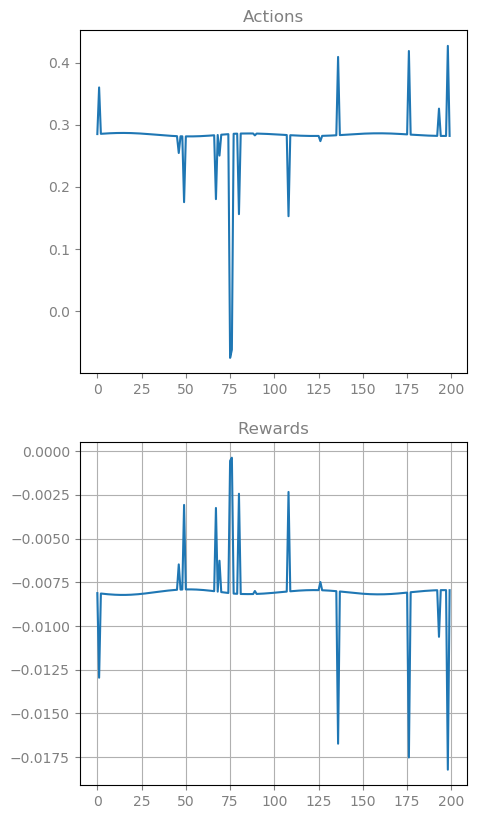

In [126]:
titles = {0: "States", 1: "Actions", 2: "Rewards", 3: "Next States"}
asts = np.asarray(state_transitions[-200:])
fig, axes = plt.subplots(2, 1, figsize=(5, 10), dpi=100)
for i in [1, 2]:

    axes[i - 1].plot(asts[:, i])
    axes[i - 1].set(title=titles[i])
plt.grid()
plt.show()

# Demo

In [133]:
E = 1
T = 1000
for e in range(E):
    state = ENV.reset()
    for t in range(T):
        a = agent.act(state, exploration=False)
        s,a,r,d = ENV.step(a)
        ENV.render()
        if d:
            break
ENV.close()

## Simple hardcoded agent

In [134]:
E = 1
T = 900
states = np.zeros(T * 2).reshape(T, 2)
for e in range(E):
    s = ENV.reset()
    for t in range(T):
        acc = -0.2 if s[1] < 0  else 0.2
        a = np.array([acc])
        s, r, i, d = ENV.step(a)
        states[t] = s
        ENV.render()

ENV.close()

[-5.30516760e-01  3.54539602e-04]
[-0.52981034  0.00070642]
[-0.52875733  0.001053  ]
[-0.52736564  0.00139169]
[-0.5256457   0.00171994]
[-0.5236104  0.0020353]
[-0.52127502  0.00233538]
[-0.51865707  0.00261795]
[-0.51577617  0.00288089]
[-0.51265395  0.00312223]
[-0.50931379  0.00334016]
[-0.50578074  0.00353305]
[-0.50208125  0.00369948]
[-0.49824304  0.00383821]
[-0.49429482  0.00394823]
[-0.49026609  0.00402873]
[-0.48618693  0.00407915]
[-0.48208778  0.00409915]
[-0.47799916  0.00408862]
[-0.47395147  0.00404769]
[-0.46997476  0.00397671]
[-0.46609849  0.00387626]
[-0.46235134  0.00374715]
[-0.45876097  0.00359037]
[-0.45535382  0.00340715]
[-0.45215494  0.00319888]
[-0.4491878   0.00296714]
[-0.44647411  0.00271369]
[-0.44403371  0.0024404 ]
[-0.4418844   0.00214931]
[-0.44004183  0.00184257]
[-0.43851939  0.00152244]
[-0.43732814  0.00119125]
[-0.43647672  0.00085142]
[-0.43597131  0.00050542]
[-4.35815552e-01  1.55754117e-04]
[-4.36010589e-01 -1.95036361e-04]
[-0.437155   -0.

[-1.16077306 -0.03757272]
[-1.1962895  -0.03551644]
[-1.2  0. ]
[-1.1974581  0.0025419]
[-1.19236594  0.00509216]
[-1.18470714  0.00765881]
[-1.17445805  0.01024908]
[-1.16158897  0.01286909]
[-1.14606565  0.01552331]
[-1.1278515   0.01821415]
[-1.10691018  0.02094133]
[-1.08320886  0.02370132]
[-1.05672211  0.02648674]
[-1.02743639  0.02928572]
[-0.99535506  0.03208133]
[-0.9605039   0.03485116]
[-0.92293682  0.03756708]
[-0.88274145  0.04019537]
[-0.84004421  0.04269723]
[-0.79501441  0.0450298 ]
[-0.74786658  0.04714783]
[-0.69886081  0.04900578]
[-0.6483003   0.05056051]
[-0.59652619  0.05177411]
[-0.54390947  0.05261671]
[-0.49084053  0.05306895]
[-0.43771687  0.05312366]
[-0.38493023  0.05278664]
[-0.33285386  0.05207637]
[-0.28183127  0.05102259]
[-0.23216708  0.04966418]
[-0.18412063  0.04804646]
[-0.13790239  0.04621824]
[-0.09367325  0.04422914]
[-0.05154603  0.04212721]
[-0.01158899  0.03995704]
[0.02616956 0.03775855]
[0.06173582 0.03556625]
[0.09514483 0.03340901]
[0.12645

[0.6  0.07]
[0.6  0.07]
[0.6  0.07]
[0.6  0.07]
[0.6  0.07]
[0.6  0.07]
[0.6  0.07]
[0.6  0.07]
[0.6  0.07]
[0.6  0.07]
[0.6  0.07]
[0.6  0.07]
[0.6  0.07]
[0.6  0.07]
[0.6  0.07]
[0.6  0.07]
[0.6  0.07]
[0.6  0.07]
[0.6  0.07]
[0.6  0.07]
[0.6  0.07]
[0.6  0.07]
[0.6  0.07]
[0.6  0.07]
[0.6  0.07]
[0.6  0.07]
[0.6  0.07]
[0.6  0.07]


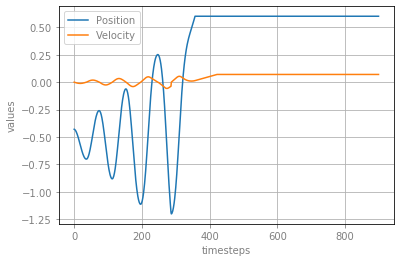

In [75]:
plt.plot(states[:, 0], label="Position")
plt.plot(states[:, 1], label="Velocity")
plt.ylabel("values")
plt.xlabel("timesteps")
plt.grid()
plt.legend()